<a href="https://colab.research.google.com/github/VladislavTokarev02/AI_ML_homework/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

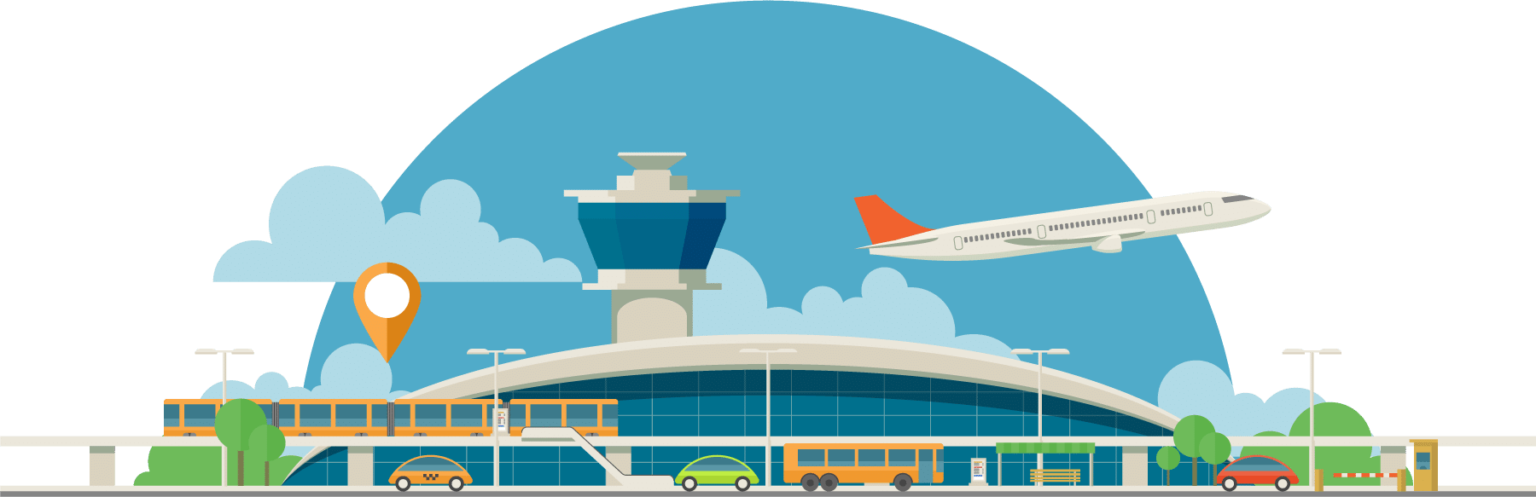

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-01 19:53:24--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-01 19:53:25 (2.53 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

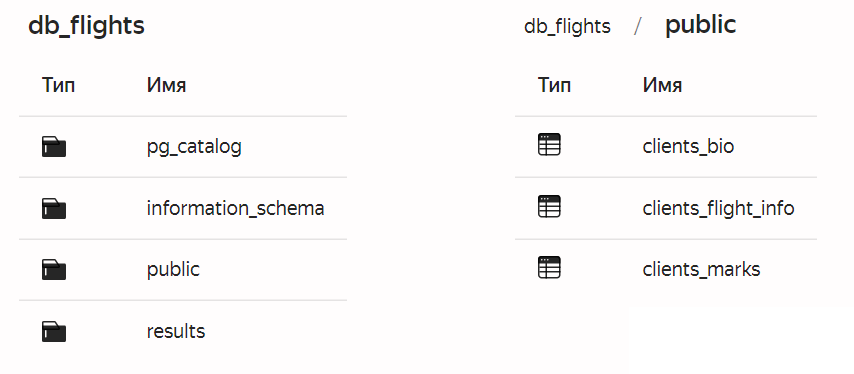



In [4]:
connection_params = {
    "dbname": "db_flights",
    "user": "mlhs_student",
    "password": "mlhs_student",
    "host": "rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port": "6432",
    "sslmode": "verify-full"
}

query = """ SELECT *
FROM clients_bio  as cl
LEFT JOIN clients_flight_info as cl_info ON cl.id=cl_info.id
LEFT JOIN clients_marks as cm ON cl.id = cm.id
    """




# Соединение с БД и загрузка данных
with psycopg2.connect(**connection_params) as conn:
    data = pd.read_sql_query(query, conn)


pd.set_option('display.max_columns', None)


data = data.T.drop_duplicates(keep='first').T
data.set_index('id', inplace = True)
data.head()

<ipython-input-4-1c77280ce1b3>:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, conn)


,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,3.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,2.0,4.0,5.0,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,2.0,1.0,4.0,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [5]:
data.describe()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
count,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549
unique,2,264,3,3,4,4058,522,533,23,24,24,24,25,22,22,22,21,26,23,23,27,22,3
top,Female,39.0,Loyal Customer,Business travel,Business,337.0,0.0,0.0,2.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,neutral or dissatisfied
freq,65726,3653,105763,89405,61939,837,73090,72489,32220,31779,30292,35594,30474,38353,39641,36693,38582,35775,46621,36222,47157,33877,58732


### Общие наблюдения
- Необходимо избавиться от выбросов в возрасте
- Привести в формат float колонки с числовыми значениями
- В категориальных колонках есть пропуски и выбросы. Выбросы есть как правило там, где пользователь оставляет оценку об уровне сервиса от 1 до 5. В свою очередь, пропуски в категориальных признаках отмечены как nan.

In [6]:
data_num = data.drop(columns = ['gender', 'Customer Type', 'Type of Travel', 'satisfaction', 'class'])
data_txt = data[['gender', 'Customer Type', 'Type of Travel', 'satisfaction', 'class']]

num_col = data_num.columns
cat_col = data_txt.columns

 #В столбцах с категориальными признаками есть nan, но поскольку они не числовые, матричный график визуализации их не видит, прэтому необходимо явно указывать этою
data_txt.replace('nan', np.nan, inplace = True)

for i in data_num:
  data_num[i] = data_num[i].astype('float')

data = pd.merge(data_num, data_txt, how = 'left', on='id')

<ipython-input-6-1b22c44ba83e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt.replace('nan', np.nan, inplace = True)


### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

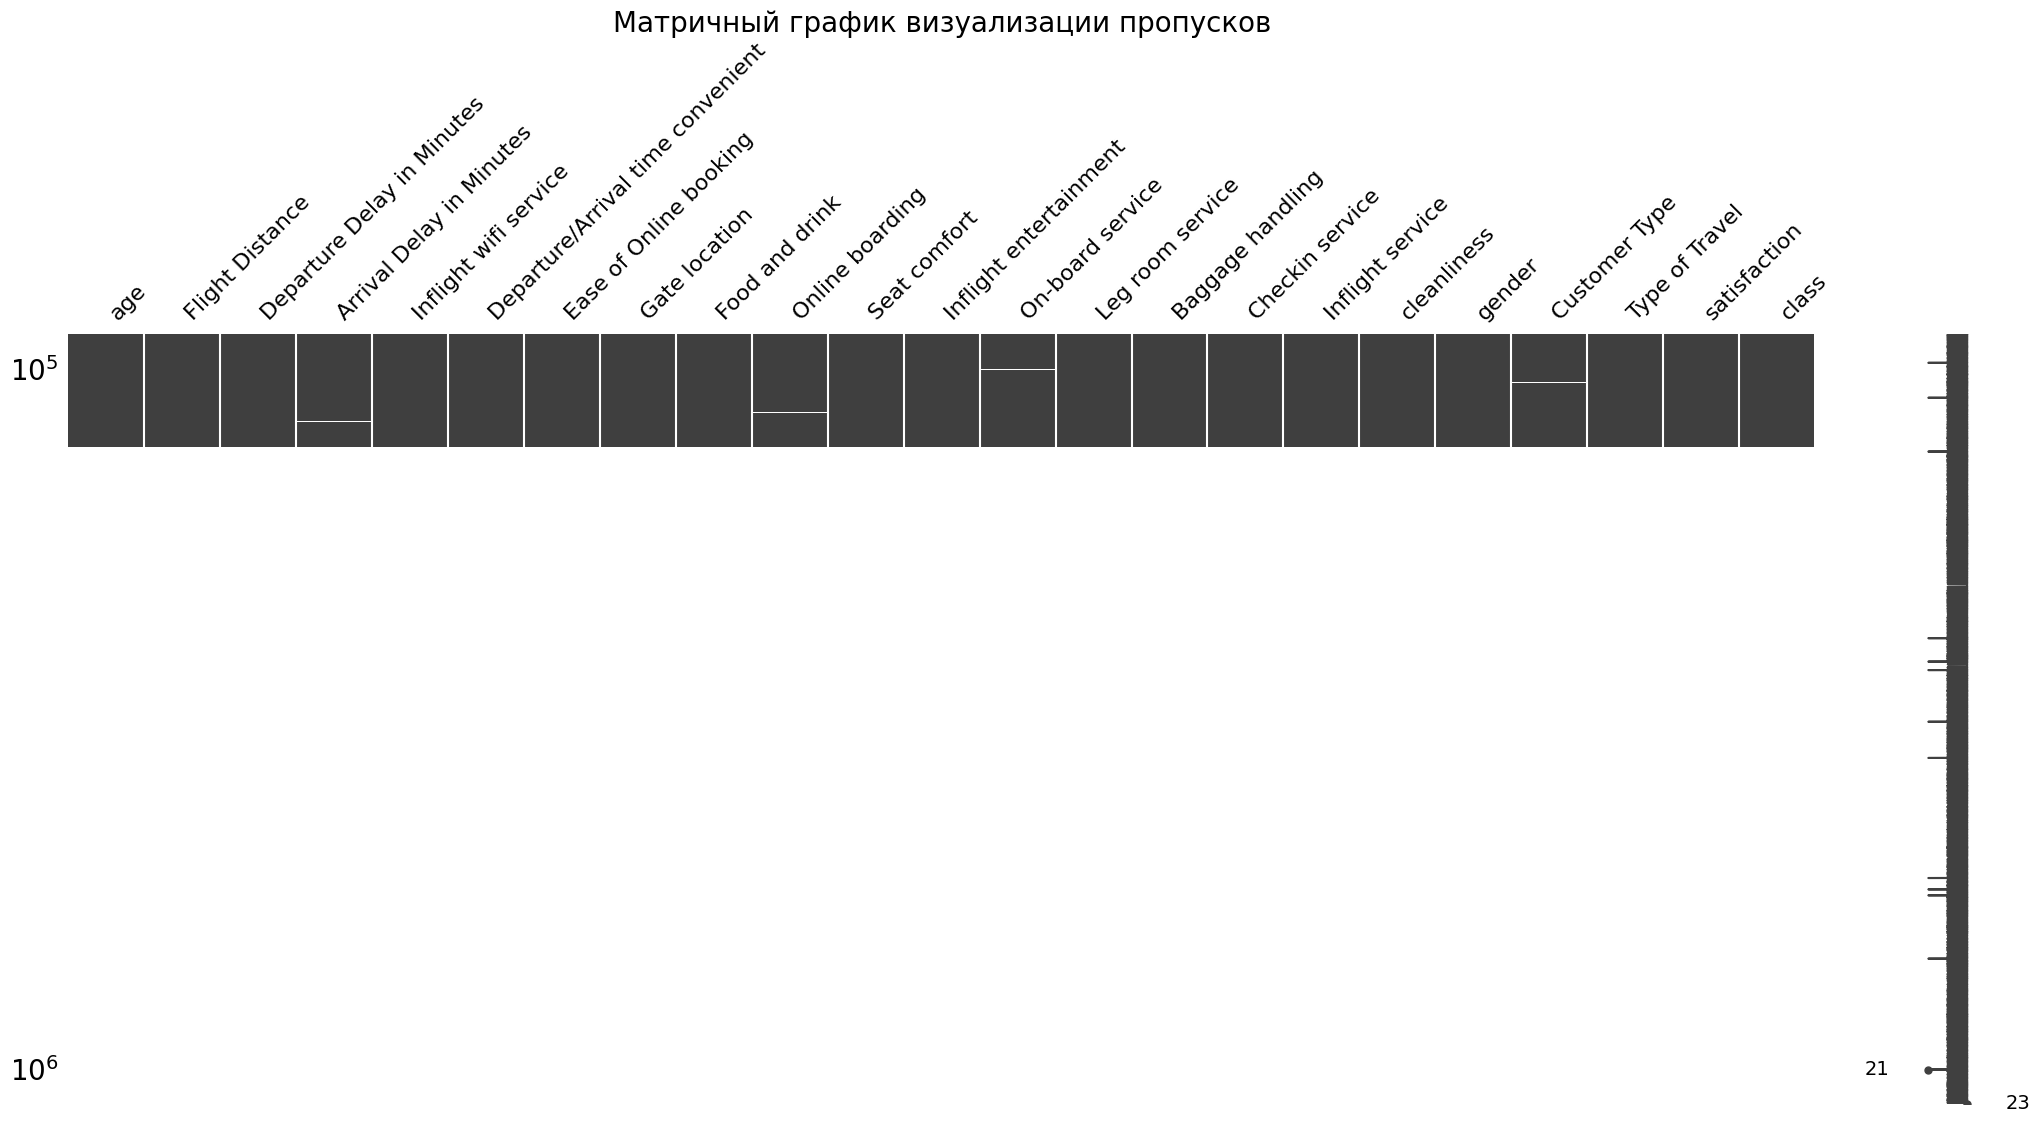

<Figure size 1000x500 with 0 Axes>

In [7]:
msno.matrix(data)
plt.yscale('log') # Логарифмированная шкала
plt.title('Матричный график визуализации пропусков', fontsize = 20)
plt.figure(figsize=(10, 5))
plt.show()

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [8]:
df_train = data[data.satisfaction != '-']
df_train

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,gender,Customer Type,Type of Travel,satisfaction,class
id,,,,,,,,,,,,,,,,,,,,,,,
7,43.0,1963.0,0.0,0.0,3.0,3.0,3.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,Male,Loyal Customer,Business travel,satisfied,Business
13,24.0,453.0,16.0,30.0,2.0,2.0,2.0,4.0,5.0,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,Male,disloyal Customer,Business travel,neutral or dissatisfied,Eco
18,61.0,821.0,0.0,0.0,2.0,5.0,2.0,1.0,4.0,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,Female,Loyal Customer,Personal Travel,neutral or dissatisfied,Eco
31,35.0,212.0,0.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,Male,disloyal Customer,Business travel,neutral or dissatisfied,Business
39,46.0,67.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,Female,Loyal Customer,Business travel,satisfied,Business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129831,28.0,447.0,23.0,16.0,1.0,3.0,1.0,5.0,3.0,1.0,3.0,3.0,1.0,1.0,4.0,1.0,5.0,3.0,Female,Loyal Customer,Personal Travel,neutral or dissatisfied,Eco
129837,66.0,337.0,199.0,213.0,2.0,4.0,2.0,3.0,2.0,5.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,5.0,Male,Loyal Customer,Personal Travel,neutral or dissatisfied,Eco
129838,59.0,308.0,32.0,24.0,3.0,5.0,3.0,4.0,2.0,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,Female,Loyal Customer,Personal Travel,neutral or dissatisfied,Eco


In [9]:
assert df_train.shape == (103_644, 23)

In [10]:
df_test = data[data.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,gender,Customer Type,Type of Travel,class
id,,,,,,,,,,,,,,,,,,,,,,
55,36.0,3655.0,40.0,71.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0,Male,Loyal Customer,Business travel,Business
79,70.0,108.0,50.0,41.0,5.0,4.0,0.0,3.0,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0,Female,Loyal Customer,Personal Travel,Eco
126,66.0,562.0,88.0,84.0,2.0,5.0,2.0,4.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0,Male,Loyal Customer,Personal Travel,Eco
199,60.0,3756.0,36.0,24.0,4.0,4.0,4.0,4.0,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,Female,Loyal Customer,Business travel,Business
263,43.0,802.0,0.0,0.0,1.0,2.0,1.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,Male,Loyal Customer,Personal Travel,Business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129750,38.0,337.0,92.0,82.0,4.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0,Male,Loyal Customer,Business travel,Eco
129771,16.0,308.0,2.0,0.0,3.0,4.0,3.0,3.0,1.0,3.0,5.0,1.0,4.0,2.0,5.0,5.0,4.0,1.0,Male,Loyal Customer,Personal Travel,Eco
129798,43.0,308.0,0.0,0.0,2.0,4.0,2.0,2.0,3.0,5.0,5.0,4.0,4.0,2.0,4.0,4.0,4.0,5.0,Female,Loyal Customer,Personal Travel,Eco


In [11]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [12]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [13]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [14]:
imputer = SimpleImputer(strategy='most_frequent').set_output(transform="pandas")

# На трейне обучим и применим
X_train = imputer.fit_transform(X_train)
X_train[num_col] = X_train[num_col].apply(pd.to_numeric, errors='coerce')

# На валидации только применим
X_val = imputer.transform(X_val)
X_val[num_col] = X_val[num_col].apply(pd.to_numeric, errors='coerce')

# На тесте только применим
df_test = imputer.transform(df_test)
df_test[num_col] = df_test[num_col].apply(pd.to_numeric, errors='coerce')

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [15]:
X_train.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000
mean,40.098856,1329.018332,15.859366,16.645968,2.733687,3.065017,2.761006,2.982688,3.209318,3.256513,3.445665,3.362150,3.383101,3.352364,3.630255,3.309056,3.640234,3.291178
std,20.658196,4764.369357,70.861937,97.990293,1.362172,1.552254,1.414843,1.316648,1.349963,1.372739,1.346077,1.360862,1.333758,1.360180,1.227853,1.293114,1.215114,1.343302
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,544.000000,379620.000000,9282.000000,11760.000000,45.000000,45.000000,28.000000,36.000000,36.000000,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


In [16]:
X_train.describe(include = 'object')

,gender,Customer Type,Type of Travel,class
count,72550,72550,72550,72550
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,36816,59406,50054,34793


Выводы о распределениях значений признаков:

- Главной особенностью данных кажется наличие выбросов, они есть во всех числовых столбцах
- Обратим внимание, что 14 колонок датасета представляют собой обратную связь от клиентов авиакомпании, составленную по 10-балльной шкале.

Таким образом, если избавиться от выбросов, которые были составлены вероятно из-за ошибок/неточностях ввода данных, можно получить более точную картину.


### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [17]:
quantiles = X_train[num_col].quantile(0.996)


mask_train = (X_train[num_col] <= quantiles).all(axis=1)
mask_val = (X_val[num_col] <= quantiles).all(axis=1)


X_train = X_train[mask_train]
y_train = y_train[mask_train]
X_val = X_val[mask_val]
y_val = y_val[mask_val]

print("Размерность трейна после удаления выбросов: X =", X_train.shape, "y =", y_train.shape)
print("Размерность валидации после удаления выбросов: X =", X_val.shape, "y =", y_val.shape)
print("Размерность теста (не изменялась):", df_test.shape)

Размерность трейна после удаления выбросов: X = (71395, 22) y = (71395,)
Размерность валидации после удаления выбросов: X = (30600, 22) y = (30600,)
Размерность теста (не изменялась): (25905, 22)


In [18]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [19]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(data.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(data.select_dtypes(include='object').columns)[:-1]
categorical_cols[-1] = 'class'

In [20]:
categorical_cols

['gender', 'Customer Type', 'Type of Travel', 'class']

In [21]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [22]:
def plot_ordinal(cols, df, y):
    n_cols = len(cols)
    n_rows = (n_cols + 1) // 4
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))
    fig.suptitle('Распределения порядковых признаков по "satisfaction"', fontsize=18)

    if n_cols == 1:
        axes = np.array([[axes]])

    axes = axes.flatten()

    for i, (ax, col) in enumerate(zip(axes, cols)):
        sns.countplot(data=df, x=col, hue=y, ax=ax)
        ax.set_title(f'"{col}"', fontsize=16)
        ax.set_xlabel(f'Оценка за "{col}"')
        ax.set_ylabel('Количество')
        ax.tick_params(axis='x')
        ax.legend(loc='upper left')

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [23]:
def plot_continuous(cols, df, y):
    n_cols = len(cols)
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(4, n_cols, height_ratios=[0.2, 2, 0.2, 1])

    title_ax1 = fig.add_subplot(gs[0, :])
    title_ax1.text(0.5, 0.5, 'Распределения непрерывных признаков',
                  horizontalalignment='center', fontsize=18)
    title_ax1.axis('off')

    title_ax2 = fig.add_subplot(gs[2, :])
    title_ax2.text(0.5, 0.5, 'Диаграммы размаха',
                  horizontalalignment='center', fontsize=18)
    title_ax2.axis('off')

    axes = [[fig.add_subplot(gs[1, i]) for i in range(n_cols)],
            [fig.add_subplot(gs[3, i]) for i in range(n_cols)]]

    for i, col in enumerate(cols):
        sns.kdeplot(data=df, x=col, hue=y, ax=axes[0][i])
        axes[0][i].set_title(f'"{col}" по "satisfaction"')
        axes[0][i].set_xlabel(col)
        axes[0][i].set_ylabel('Плотность')

        sns.boxplot(data=df, x=y, y=col, ax=axes[1][i], hue=y)
        axes[1][i].set_title(f'"{col}" по "satisfaction"')
        axes[1][i].set_xlabel('satisfaction')
        axes[1][i].set_ylabel(col)

    plt.tight_layout()
    plt.show()

In [24]:
def plot_categorical(cols, df, y):
  for col in cols:
      plt.figure(figsize=(6, 4))
      sns.countplot(x=col, hue=y, data=df, palette='Set1')
      plt.xlabel(f'{col}')
      plt.ylabel('Count')
      plt.title(f'Countplot of {col}')
      plt.show()

Отрисовка.

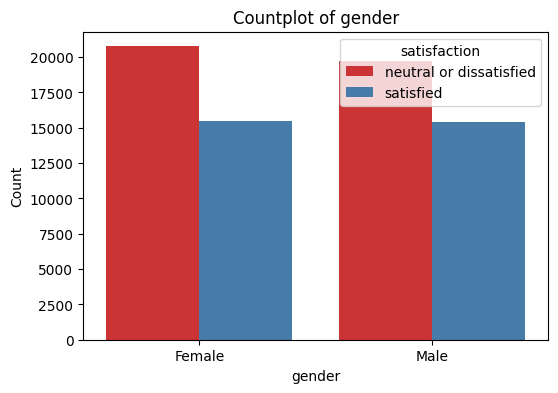

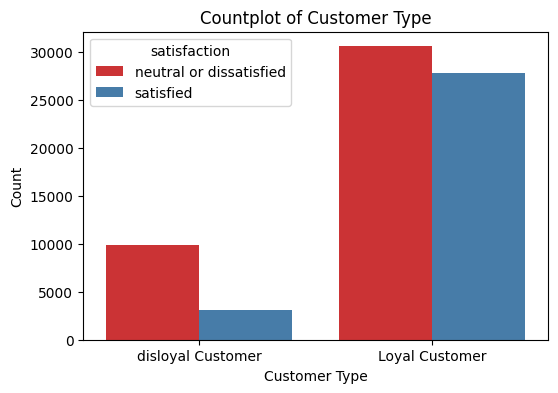

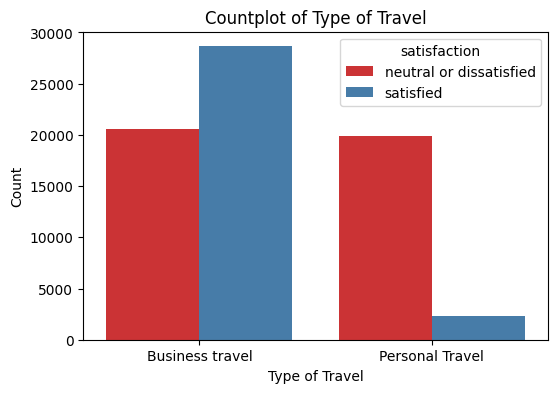

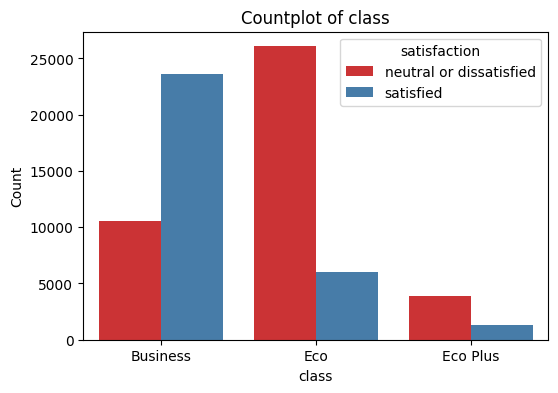

In [25]:
plot_categorical(categorical_cols, X_train, y_train)

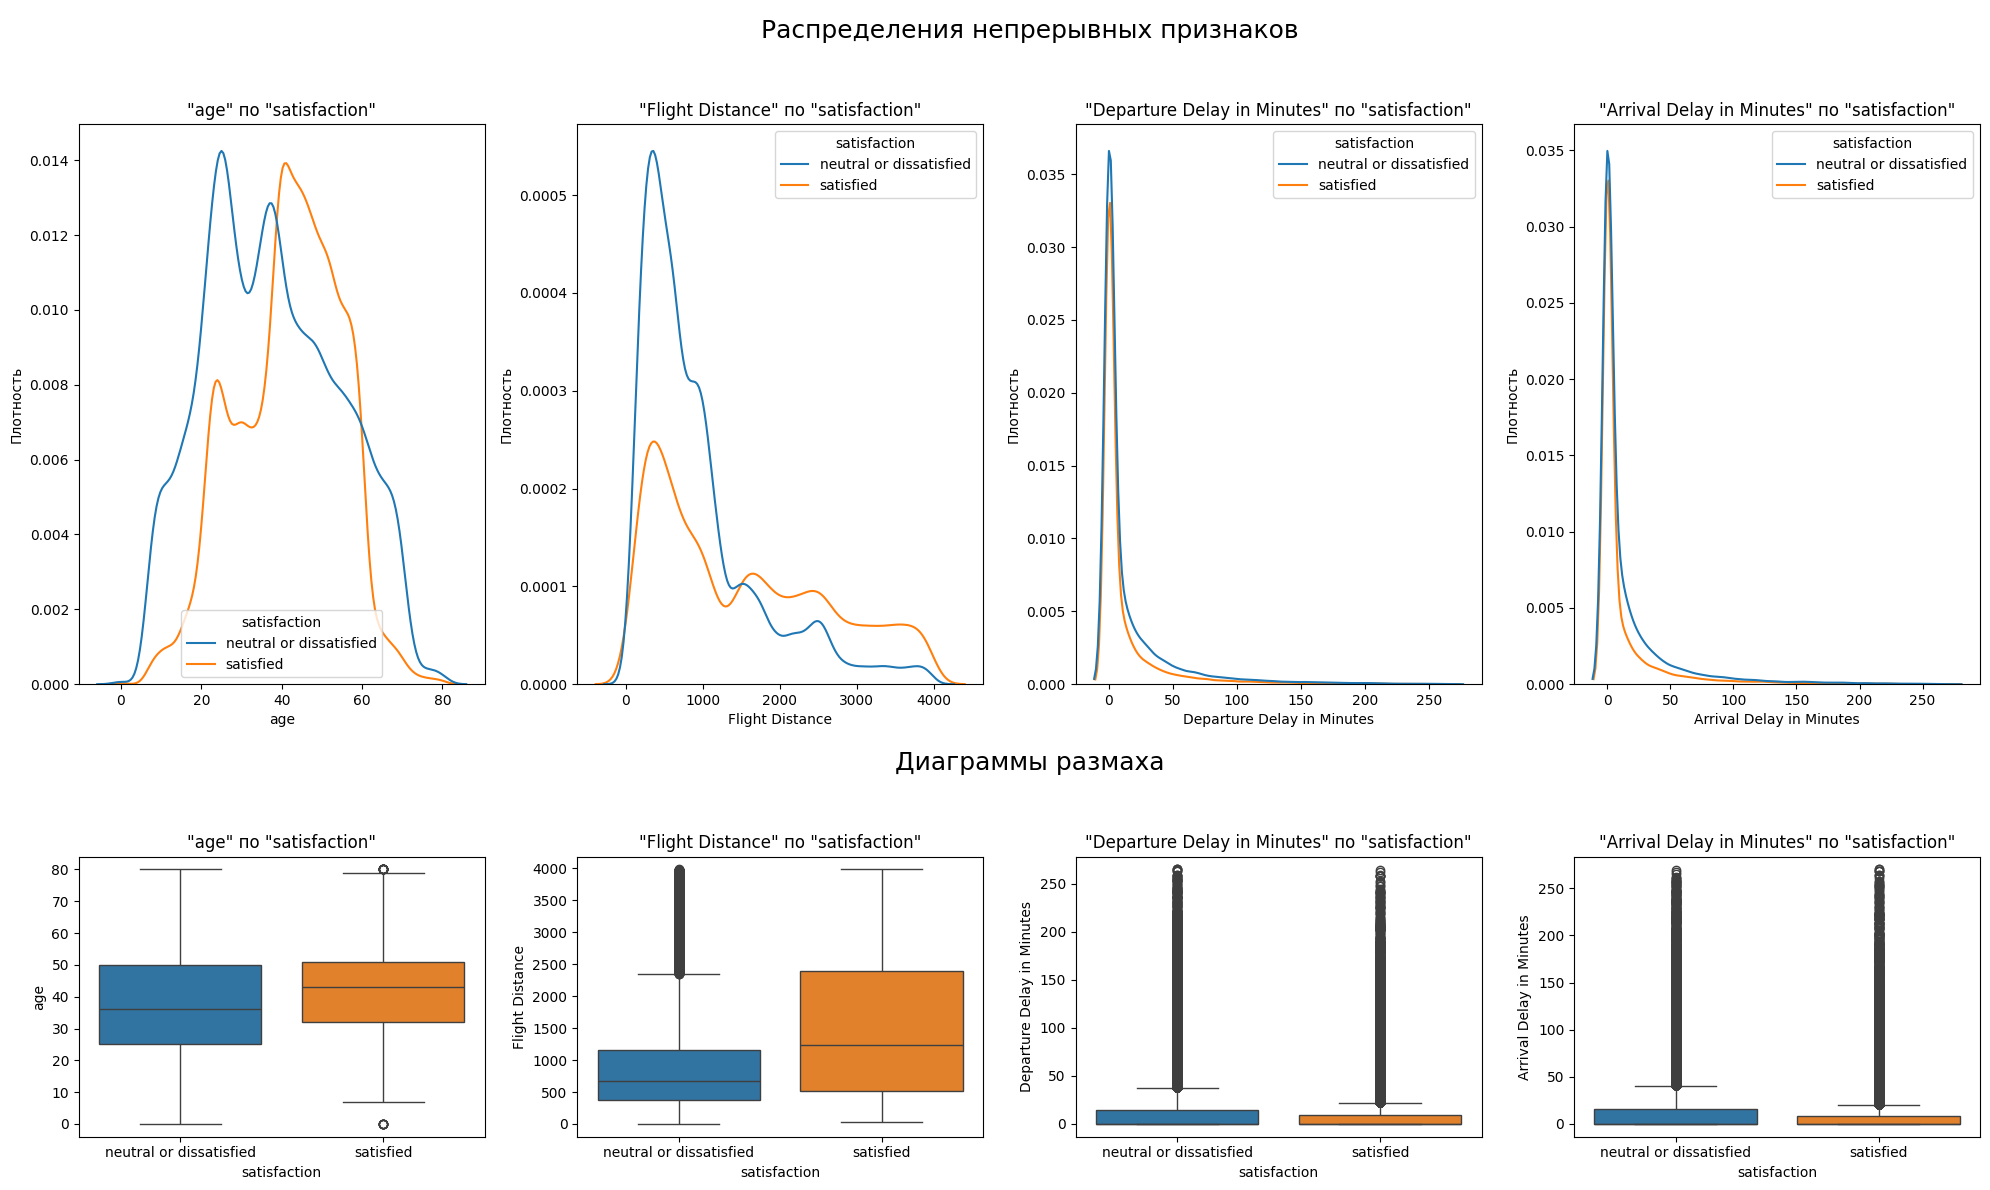

In [26]:
plot_continuous(continuous_cols, X_train, y_train)

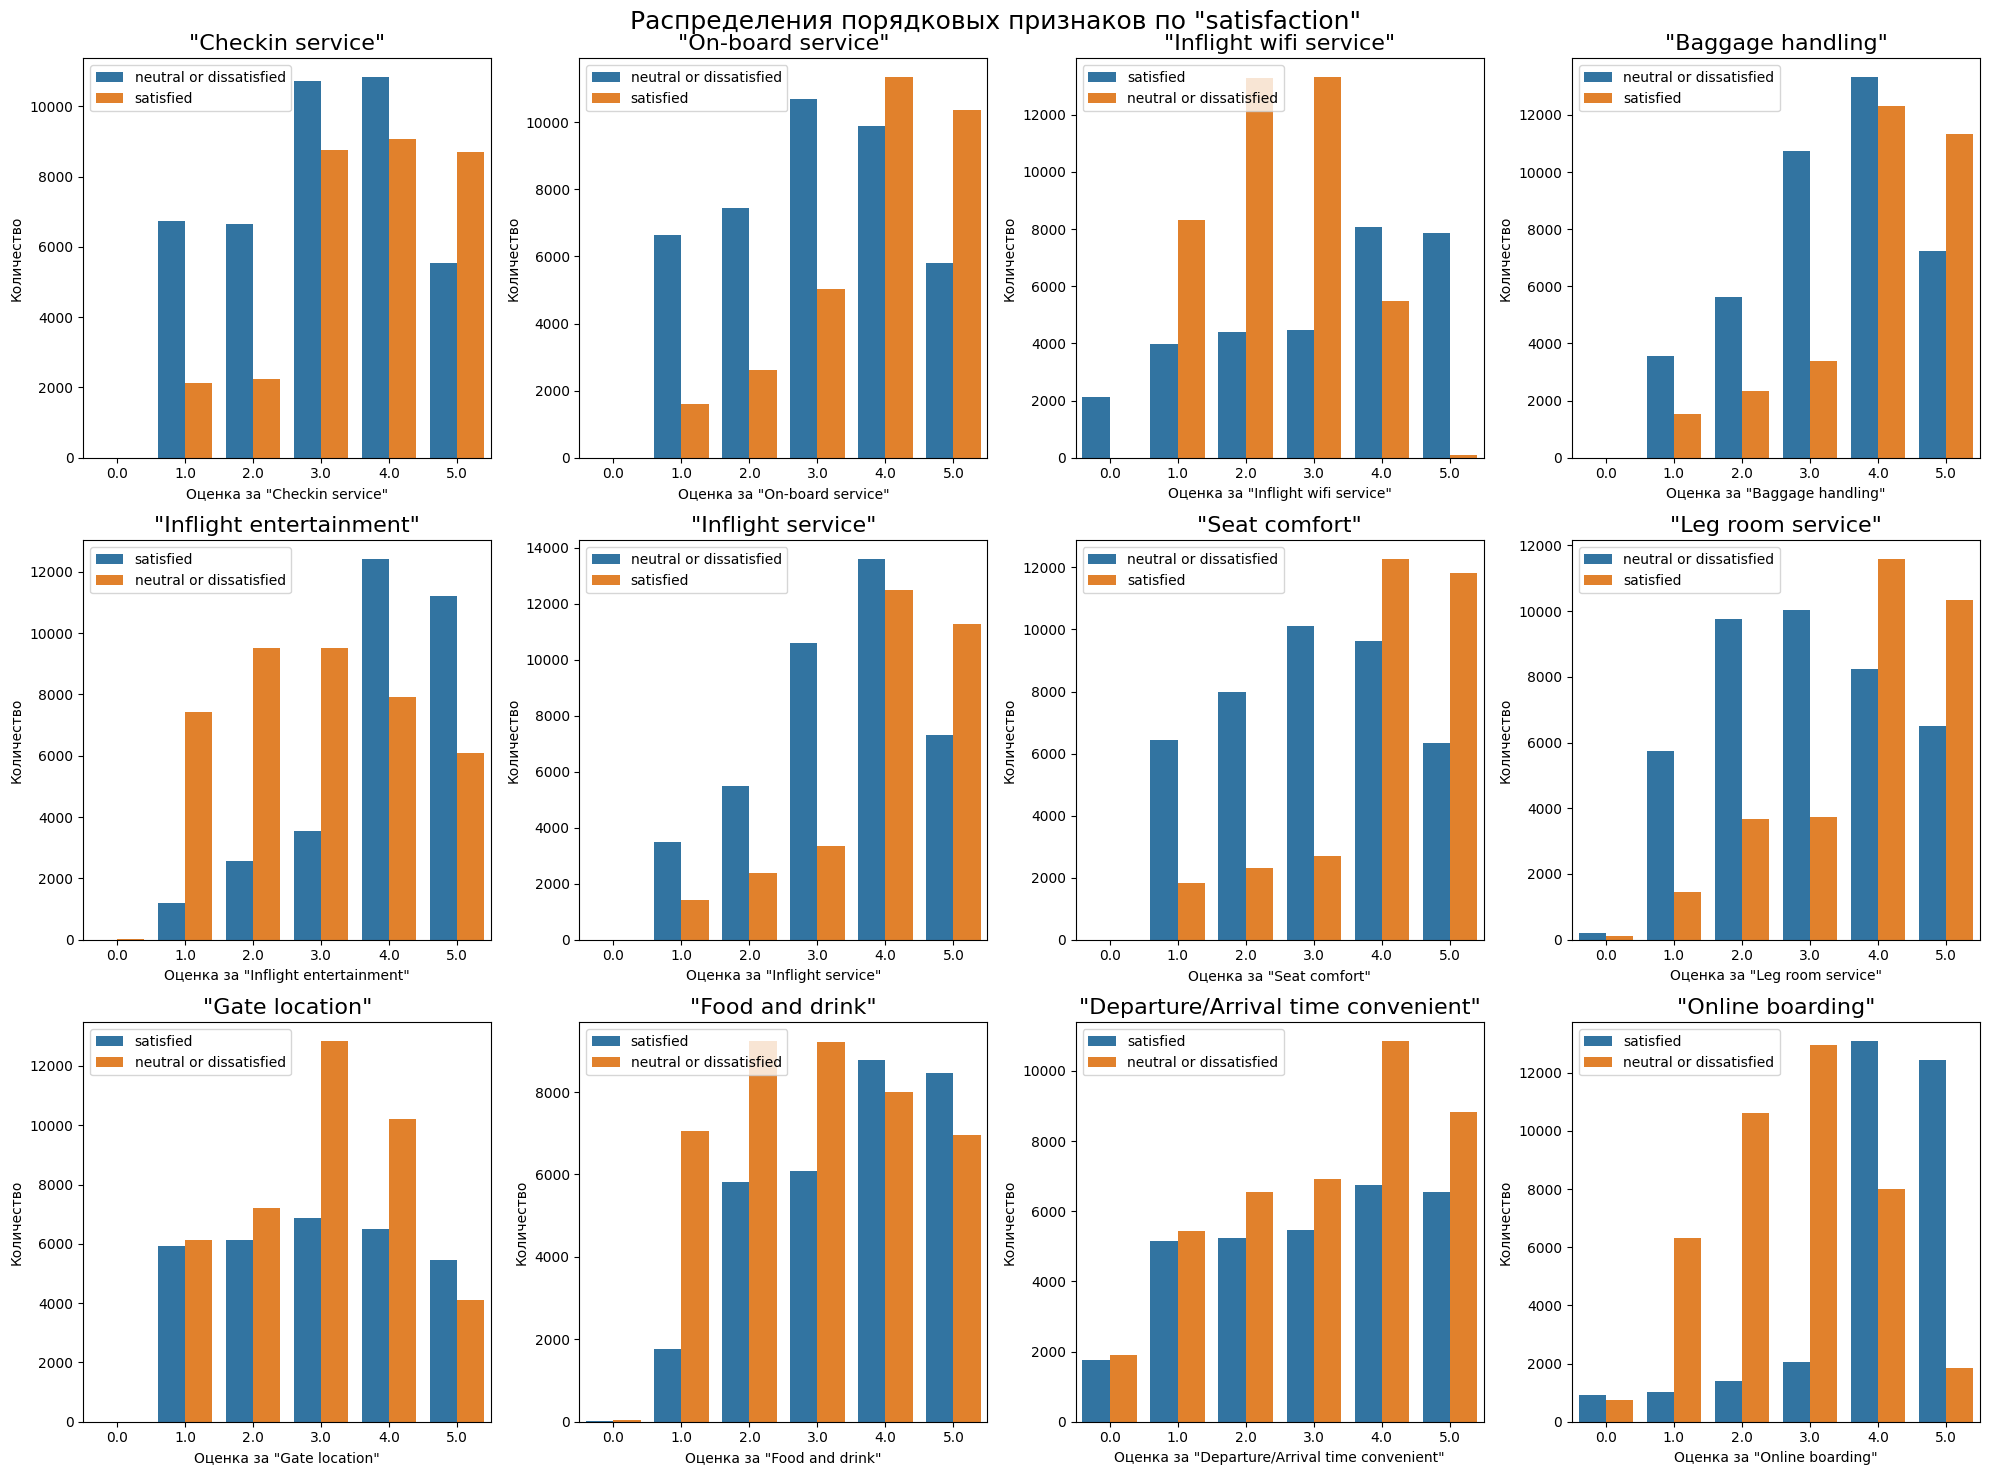

In [27]:
plot_ordinal(ordinal_cols, X_train, y_train)

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

In [28]:
for column in categorical_cols:
    print("-", column, "-")
    print(data[column].value_counts())

- gender -
gender
Female    65726
Male      63823
Name: count, dtype: int64
- Customer Type -
Customer Type
Loyal Customer       105763
disloyal Customer     23709
Name: count, dtype: int64
- Type of Travel -
Type of Travel
Business travel    89405
Personal Travel    40043
Name: count, dtype: int64
- class -
class
Business    61939
Eco         58115
Eco Plus     9379
Name: count, dtype: int64


<b> Тезисно </b>
1. Сбалансированность классов
- Классы не являются сбалансированными, за исключением пола клиента
2. Неравномерно распределённые признаки
- Большинство клиентов - лояльные, однако сравнивая лояльных и нелояльных клиентов в своём масштабе отношение примерно одинаковое.
- Бизнес-путешествий получается больше, чем свободных.
- Пол клиента распределён равномерно
3. Age - бимодальное распределение, Flight Distance - нормальное с тяжелым правым хвостом, Departure Delay/Departure Array - вероятно, логнормальное.
4. Исходя из клиентских оценок в рамках удовлётворенности сервисом авиаперевозчика можно сказать, что чаще всего оценка 3/5 или 4/5.




### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

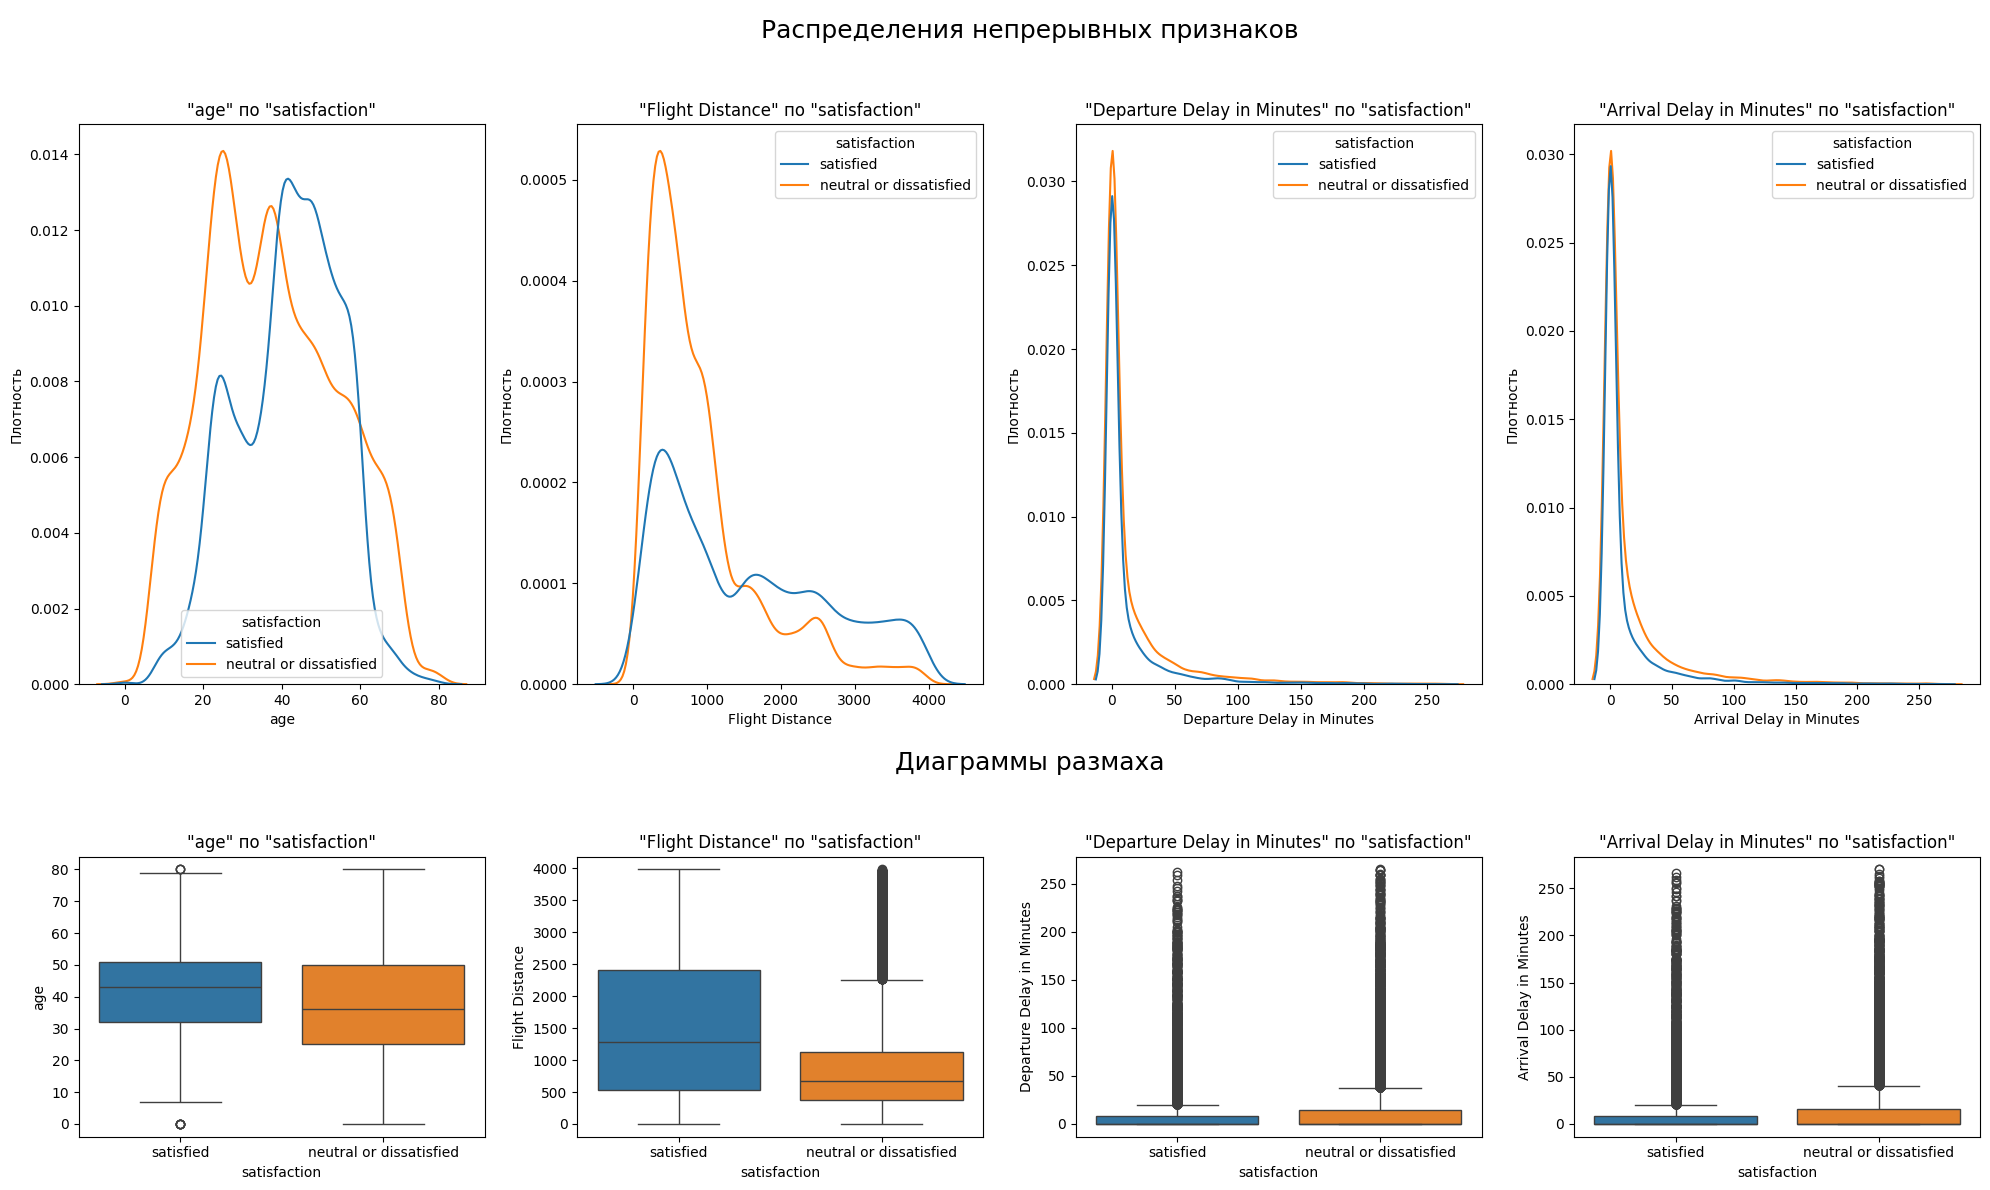

In [29]:
plot_continuous(continuous_cols, X_val, y_val)

Распределения признаков идентичны для X_train и X_val.

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [30]:
eps = 1e-8

X_train_log = X_train.copy()
X_val_log = X_val.copy()
X_test_log = df_test.copy()

X_train_log['Departure Delay in Minutes'] = np.log(X_train_log['Departure Delay in Minutes'] + eps)
X_train_log['Arrival Delay in Minutes'] = np.log(X_train_log['Arrival Delay in Minutes'] + eps)

X_val_log['Departure Delay in Minutes'] = np.log(X_val_log['Departure Delay in Minutes'] + eps)
X_val_log['Arrival Delay in Minutes'] = np.log(X_val_log['Arrival Delay in Minutes'] + eps)

X_test_log['Departure Delay in Minutes'] = np.log(X_test_log['Departure Delay in Minutes'] + eps)
X_test_log['Arrival Delay in Minutes'] = np.log(X_test_log['Arrival Delay in Minutes'] + eps)



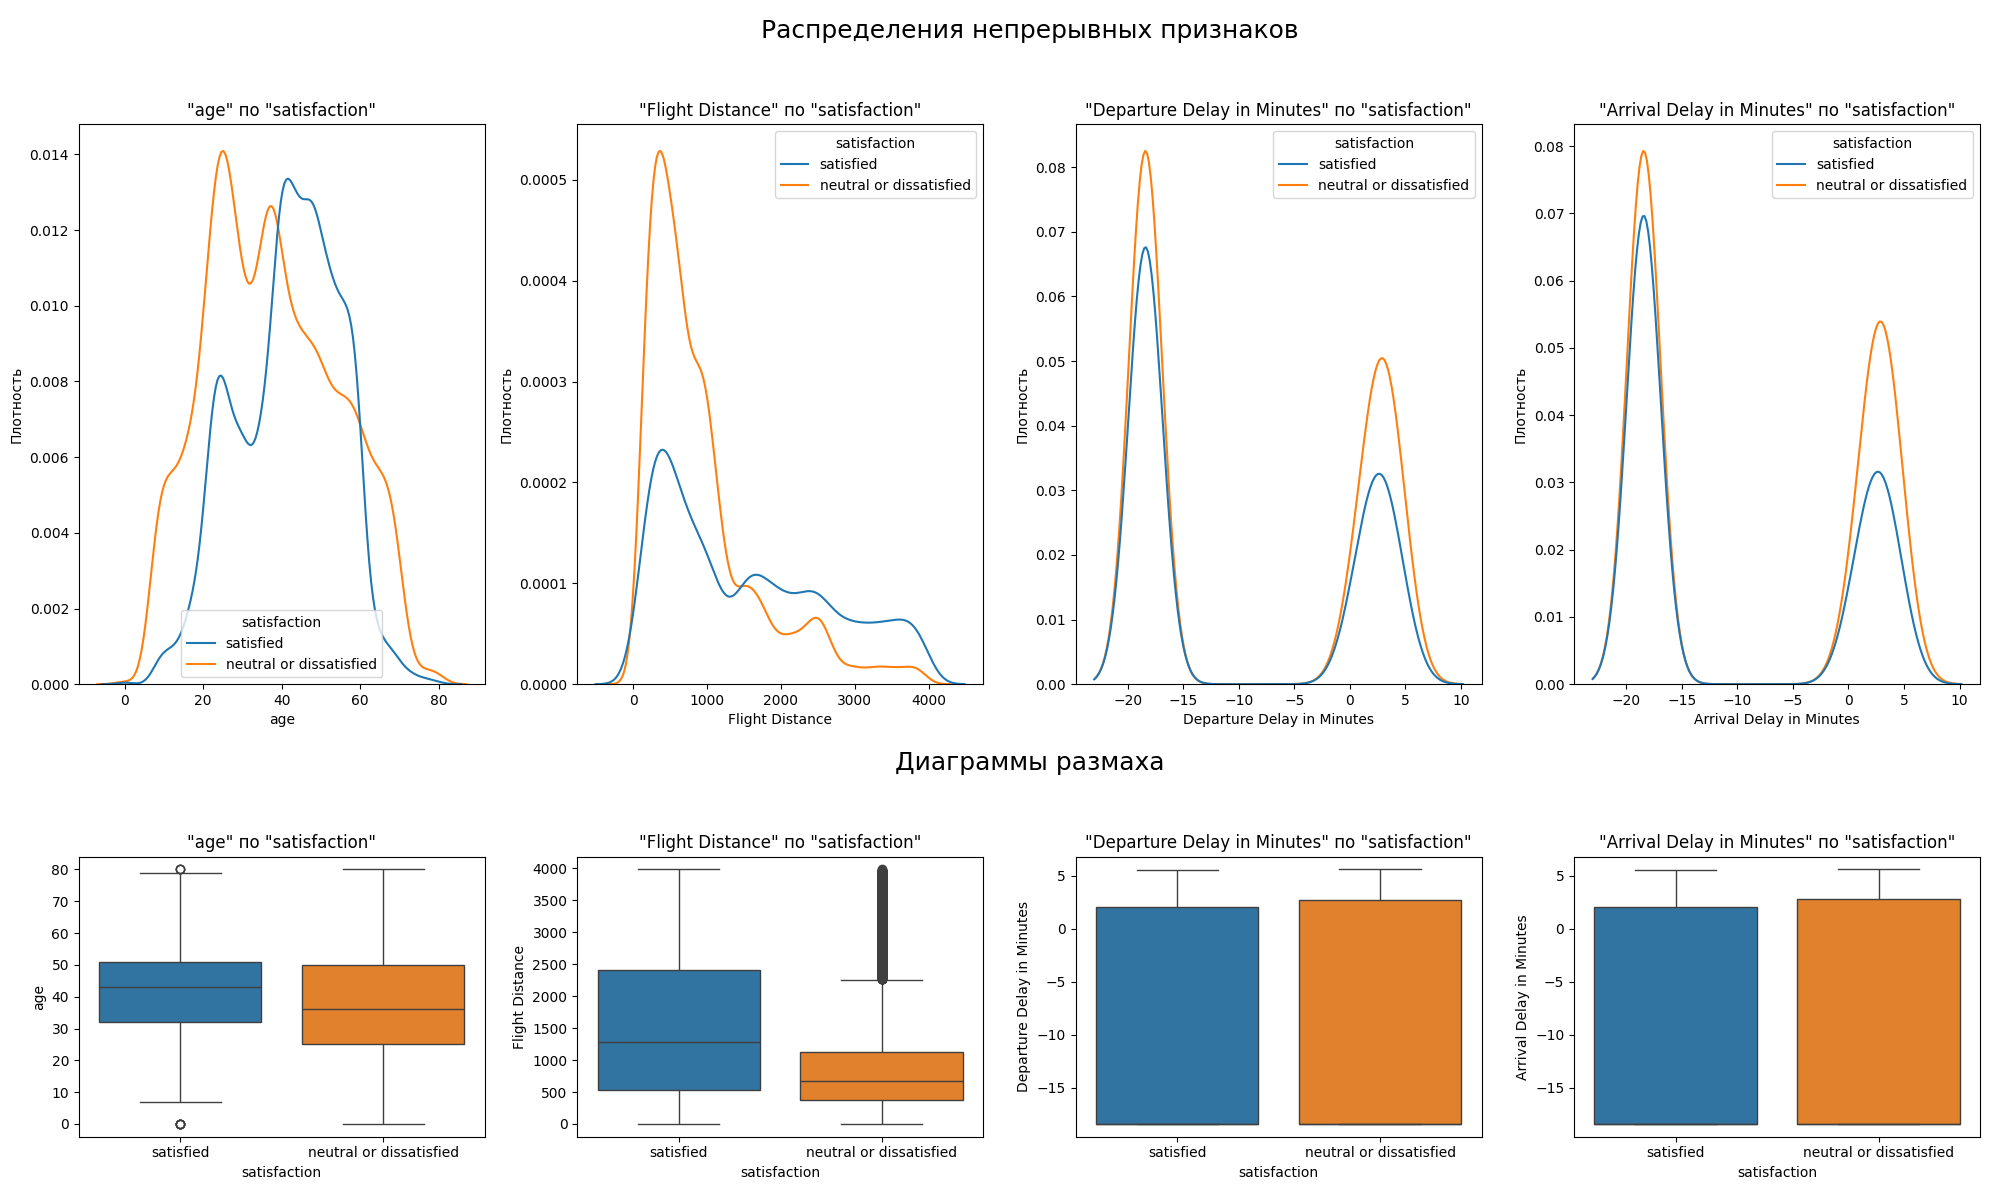

In [31]:
plot_continuous(continuous_cols, X_val_log, y_val)

Логарифмирование при построении графика бывает полезно в тех случаях, когда необходимо сравнивать величины, которые отличаются в несколько раз - масштаб графика меняется, он становится более презентабельным. С другой стороны, интерпретировать такие графики становится немного сложнее, ведь по одной оси измеряемая величина прологарифмирована.
Пример: нужно изменить масштаб графика, потому что в точечной диаграмме большая часть точек слиплась в одном углу - в таком случае поможет логарифмическая шкала.


Кроме того - логарифмирование позволяет привести логнормальное распределение - в нормальное.


В нашем случае после логарифмирования признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" стали иметь ярок выраженные бимодальные распределения.

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

Базовая операция:
```sns.pairplot(X_train_log[continuous_cols], hue= y_train)``` не помогла, пришлось сделать обходной способ

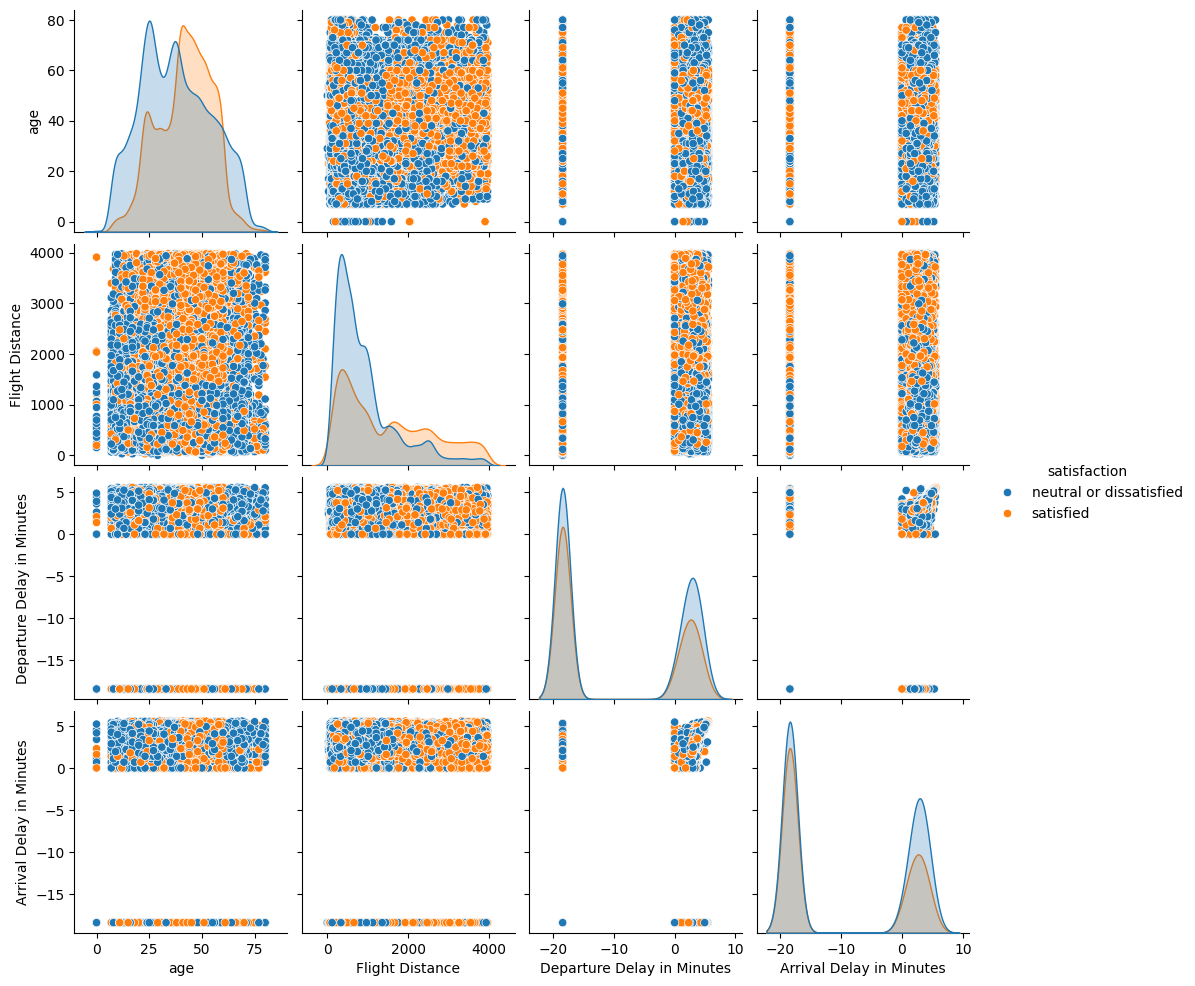

In [32]:
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train['satisfaction']
else:
    y_train_series = y_train
X_train_log_combined = pd.concat([X_train_log[continuous_cols], y_train_series], axis=1)

sns.pairplot(X_train_log_combined, hue='satisfaction')
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [33]:
y_train = y_train_series
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_train.value_counts(normalize = True)

,proportion
satisfaction,
0,0.567043
1,0.432957


In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), categorical_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [59]:
if isinstance(y_val, pd.DataFrame):
    y_val_series = y_val['satisfaction']
else:
    y_val_series = y_val
y_val = y_val_series
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0) # применили ту же технику

In [63]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

pred = model.predict(X_val)

accuracy_score(y_val, pred)

0.9425490196078431

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
# Ваш код ниже — дополните его

error_dt, bias_dt, var_dt = bias_variance_decomp
error_dt, bias_dt, var_dt

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
# Ваш код ниже

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

In [ ]:
# Ваш код здесь

`Ваш ответ здесь.`  

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
# Ваш код здесь

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

In [ ]:
# Ваш код здесь


### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

In [ ]:
# Ваш код здесь

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [ ]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
# you know what to do



### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
# Ваш код здесь



### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

In [ ]:
# Ваш код здесь



Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Ваш ответ здесь
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [ ]:
# Ваш код здесь

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ваш ответ здесь
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь (Logreg)

In [ ]:
# Ваш код здесь (isoreg)

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
# Ваш код здесь


```
Ваш ответ здесь
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
# Ваш код здесь


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# Ваш код здесь


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

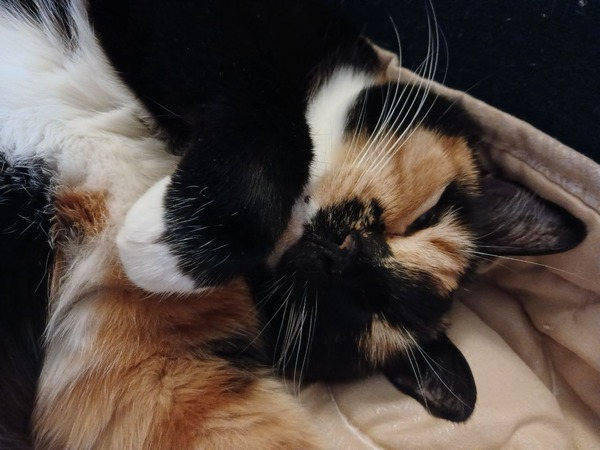

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?